# Deep Neural Networks (DNNs)

### Objectives:
- Recall some important concepts about DNNs 
- Using DNNs to solve a real-life classification problem in the banking industry
- Use of PyTorch's custom modules to define the network architecture and train the model
- Exploration of error analysis to improve the model performance


### Recall of Important Concepts

Artificial neural nets consists of dense layers and activations.

1. What's the difference between deep learning and normal machine learning?
<span style="color:blue"> 1- After a certain point, adding more data for traditional ML algorithms won't improve
	  the performance and the learning curve will saturate (plateau), but for DL, you can generally get better performance by providing more training data.
	<br/>2- There's generally no handcrafted feature extraction step in DNNs.
	<br/>3- DNNs need high computational power for training.
    
2. How does a neural network with no hidden layers and one output neuron compare to a logistic/linear regression?
<span style="color:blue"> There's no difference. NN with no hidden layers is perceptron which has the same architecture of logistic/linear regression. If the activation function in the output layer is linear and loss is mse then it is linear regression. If the activation function in the output layer is sigmoid and the loss is the logloss then it is logistic regression.
    
3. In multi-hidden layers network, what's the need of non-linear activation function?
<span style="color:blue"> To capture the non linear patterns in the relation between the input and the output, and represent it as non-linear features.
    
6. Is random weight assignment better than assigning same weights to the units in the hidden layer.
<span style="color:blue"> Yes, because random initialization helps to break symmetry in the network and promote diversity in the learning of each neuron, leading to better optimization and reducing the risk of getting stuck in suboptimal solutions. Using the same weight values across all neurons can result in the network making the same mistakes, leading to poor performance.
---

## Solving a Classification problem using DNNs

In the following sections, we will solve a classification task related to credit card payments using the Default of Credit Card Clients dataset. We will use this data to build a model that is able to determine whether a new client will default on the upcoming payment or not, thus we are solving a binary classification problem.

In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


## Loading and Preparing the Dataset

Loading the data and printing the head of the dataset. It will be a good idea to read the documentation of read_excel function at https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html

In [2]:
import pandas as pd

data = pd.read_excel("default of credit card clients.xls", \
                     skiprows=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


The shape of the dataset is 30,000 rows and 25 columns, which can be obtained using the following line of code:

In [3]:
print("rows:",data.shape[0]," columns:", data.shape[1])

rows: 30000  columns: 25


As we learned earlier in the semester, sometimes our data might contain irrelevant features which can be removed before model training. For example, in our classification problem the features ID and Sex can be considered as irrelevant and we can remove them as follows

In [4]:
data_clean = data.drop(columns=["ID", "SEX"])
data_clean.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,1,24,2,2,-1,-1,-2,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,26,-1,2,0,0,0,2,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,34,0,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,1,37,0,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,2,1,57,-1,0,-1,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Let's check if our data has any missing values.

In [5]:
total = data_clean.isnull().sum()
percent = (data_clean.isnull().sum()\
           /data_clean.isnull().count()*100)
pd.concat([total, percent], axis=1, \
          keys=['Total', 'Percent']).transpose() 

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since our data does not have any missing values, no further action is required.
<br>
However, if it had, we can handle them in several ways:

- Drop missing values: Remove all rows or columns containing missing values.
- Impute missing values: Fill in missing values with mean, median, mode, or other values.
    - SimpleImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
    - KNNImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)
- Predict missing values: Use a machine learning model to predict missing values.
    - IterativeImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)
- Using flags to indicate missing values: Add an extra column indicating the presence of missing values.
- Interpolation: Interpolating missing values based on other values.
    - scipy.interpolate.interp1d (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)
- Using external sources of data to fill missing values.

It is a good idea to check for class imbalance as well, which can be detected by simply counting the occurrences of each of the classes in the target feature, as shown here:

In [6]:
target = data_clean["default payment next month"]
yes = target[target == 1].count()
no = target[target == 0].count()
print("yes %: " + str(yes/len(target)*100) + " - no %: " \
      + str(no/len(target)*100))

yes %: 22.12 - no %: 77.88000000000001


These results can also be displayed in a plot using the following lines of code:

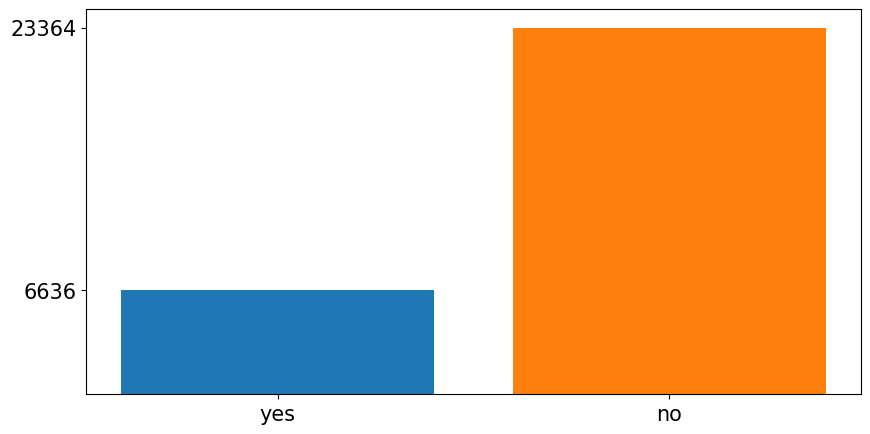

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.bar("yes", yes)
plt.bar("no", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

To resolve the issue, since no additional data can be added and accuracy is the performance metric, data resampling is required. The code below implements oversampling on the dataset, randomly duplicating rows of the class with fewer representation.

<br>

Two functions to look into are:

- sample https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

- concat https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [8]:
data_yes = data_clean[data_clean["default payment next month"] == 1]
data_no = data_clean[data_clean["default payment next month"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
                                random_state = 0)
data_resampled = pd.concat([data_no, over_sampling], \
                            axis=0)

Let's split the dataset into a features matrix and a target matrix.

In [9]:
data_resampled = data_resampled.reset_index(drop=True)
X = data_resampled.drop(columns=["default payment next month"])
y = data_resampled ["default payment next month"]

Rescale the values of the features matrix in order to avoid introducing bias to the model:

In [10]:
X = (X - X.min())/(X.max() - X.min())
X.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.117974,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,...,0.330672,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047


To ease the use of the prepared dataset for future tasks, we combine the feature (X) and target (y) matrices into a single Pandas DataFrame and save as a CSV file using the code provided below.

In [11]:
final_data = pd.concat([X, y], axis=1)
final_data.to_csv("dccc_prepared.csv", index=False)

## Model Training

We start by importing all important libraries. The most important one in today's activity is Pytorch. Please read more about Pytorch at https://pytorch.org/docs/stable/index.html

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

/Users/adilmehmoodkhan/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading the dataset we prepared for modeling in the previous step. 

In [13]:
data = pd.read_csv("dccc_prepared.csv")
data.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,...,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0


Separate the inputs and targets

In [14]:
X = data.iloc[:,:-1]
y = data["default payment next month"]

Split the data into three parts:
- training data
- vaidation data
- test data

In [15]:
X_new, X_test, y_new, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

In [16]:
print("Training sets:",X_train.shape, y_train.shape)
print("Validation sets:",X_dev.shape, y_dev.shape)
print("Testing sets:",X_test.shape, y_test.shape)

Training sets: (28036, 22) (28036,)
Validation sets: (9346, 22) (9346,)
Testing sets: (9346, 22) (9346,)


Convert the validation and testing sets into tensors, considering that the features' matrix should be of the float type, while the target matrix should not. Leave the training sets unconverted for the moment as they will undergo further transformations.

In [17]:
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)

### Tensors

It turns out neural network computations are just a bunch of linear algebra operations on tensors, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.
 

<img src="tensor_examples.svg" width="600px">

Just like Numpy arrays, Pytorch tensors can be added, multiplied, subtracted, etc.

Using PyTorch's custom modules, create a class called Classifier and define the model's architecture so that
it has 

- three hidden layers all having ReLU activation function, 
- and a output layer having Log Softmax activation function:

In [18]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 10)
        self.hidden_2 = nn.Linear(10, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)
        
    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = F.relu(self.hidden_2(z))
        z = F.relu(self.hidden_3(z))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

Instantiate the model and define all the variables required to train the model. Set the number of epochs to 50 and the batch size to 128. Use a learning rate of 0.001:

In [19]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
batch_size = 128

Train the network using the training sets. Use the validation sets to measure performance. To do this, save the loss and the accuracy for both the training and validation sets in each epoch:

In [20]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []

for e in range(epochs):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        pred_dev = model(X_dev_torch)
        dev_loss = criterion(pred_dev, y_dev_torch)

        ps_dev = torch.exp(pred_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)

    train_losses.append(running_loss/iterations)
    dev_losses.append(dev_loss)
    train_acc.append(running_acc/iterations)
    dev_acc.append(acc)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/iterations),
          "Validation Loss: {:.3f}.. ".format(dev_loss),
          "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
          "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/50..  Training Loss: 0.672..  Validation Loss: 0.627..  Training Accuracy: 0.576..  Validation Accuracy: 0.660
Epoch: 2/50..  Training Loss: 0.616..  Validation Loss: 0.607..  Training Accuracy: 0.667..  Validation Accuracy: 0.676
Epoch: 3/50..  Training Loss: 0.605..  Validation Loss: 0.604..  Training Accuracy: 0.684..  Validation Accuracy: 0.682
Epoch: 4/50..  Training Loss: 0.597..  Validation Loss: 0.597..  Training Accuracy: 0.692..  Validation Accuracy: 0.689
Epoch: 5/50..  Training Loss: 0.594..  Validation Loss: 0.595..  Training Accuracy: 0.693..  Validation Accuracy: 0.690
Epoch: 6/50..  Training Loss: 0.590..  Validation Loss: 0.593..  Training Accuracy: 0.695..  Validation Accuracy: 0.691
Epoch: 7/50..  Training Loss: 0.589..  Validation Loss: 0.592..  Training Accuracy: 0.693..  Validation Accuracy: 0.689
Epoch: 8/50..  Training Loss: 0.585..  Validation Loss: 0.588..  Training Accuracy: 0.695..  Validation Accuracy: 0.691
Epoch: 9/50..  Training Loss: 0.581..  V

Plot both the training and the validation loss

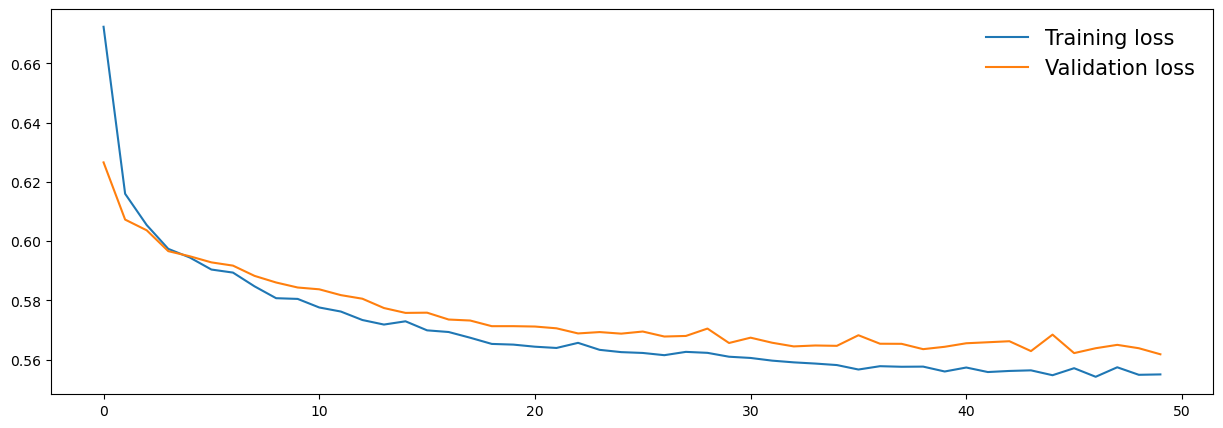

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

Also plot the training and the validation accuracy

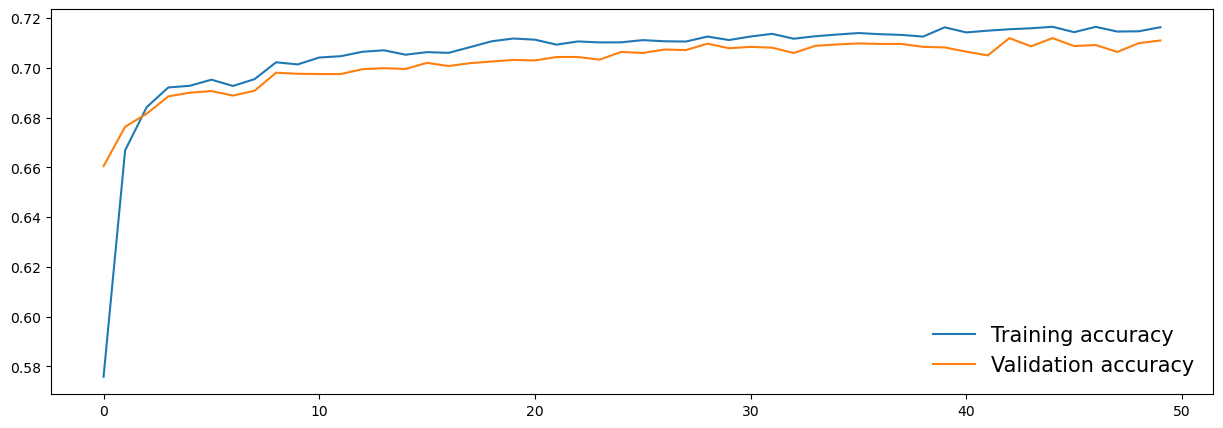

In [22]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_acc, label="Training accuracy")
plt.plot(dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

## Self-Learning Task

Based on the error and training curves, what do you think - is the model underfitting or overfitting? Based on your answer, take steps to overcome the issue and demonstrate to yourself that after making those changes the model works better. 

For example, if the model is suffering from high bias, one thing you can do is to increase the number of epochs or increase the size of the network by adding additional layers or units to each layer. The aim should be to approximate the accuracy over the validation set to 80%.

Once you have found a model which is performing well on the validation data, test it on the test set to see its final performance, as shown below.

In [23]:
model.eval()
test_pred = model(X_test_torch)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(y_test_torch, top_class_test)
print(acc_test)

0.7105713674299166
